Control Flow Prediction -> Part 2: Suffix Training
===


Process Prediction that focuses only on the control flow perspective of processes

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas
from exp.control_flow_prediction import *

In [3]:
log=import_xes(untar_data(URLs.BPIC_2012)).events

In [4]:
cfl=ControlFlowList.from_df(log)
sd=SplitData.split_by_func(cfl, partial(random_splitter, p_valid=0.1))
proc_tok,proc_num = TokenizeProcessor(),NumericalizeProcessor()
ll = label_by_func(sd, lambda x: 0, proc_x = [proc_tok,proc_num])
ll

SplitData
Train: LabeledData
x: ControlFlowList (10667 items)
['9->10->12->4->4->16->13->17->14->15->5->4->5->5->5->5->5->19->7->5->7->21->22->24->23->7->3', '9->10->12->4->4->4->4->16->17->13->14->15->5->4->5->5->5->13->18->14->15->5->5->5->5->5->19->7->5->7->7->7->7->7->24->22->21->23->7->3'...]
y: ControlFlowList (10667 items)
['0', '0'...]

Valid: LabeledData
x: ControlFlowList (1303 items)
['9->10->12->4->4->4->4->16->17->13->14->15->5->4->5->19->7->5->7->24->21->23->22->7->3', '9->10->11->3'...]
y: ControlFlowList (1303 items)
['0', '0'...]

Test: LabeledData
x: ControlFlowList (1117 items)
['9->10->12->4->4->4->4->4->4->4->4->16->17->13->14->15->5->4->5->13->18->14->15->5->5->5->5->5->5->5->5->5->13->18->14->15->5->5->5->5->5->5->5->5->5->5->5->5->5->19->7->5->7->24->22->21->23->7->27->3', '9->10->12->4->4->4->4->4->4->4->4->16->13->17->14->15->5->4->5->5->5->5->5->5->5->5->5->5->5->5->5->5->5->19->7->5->7->6->7->6->6->6->6->6->6->6->7->6->7->6->7->6->6->6->7->6->7->6->7->6->6->

In [5]:
#export
def _prepare_suffix_prediction(ds, test=False):
    x,y=[],[]
    
    for o in ds.x.items:
        if len(o)<=1: continue
        x.append(tensor(o[:len(o)//2]))
        y.append(tensor(o[len(o)//2:]))
    return x,y

def suffix_data_set(data):
    return Dataset(*_prepare_suffix_prediction(data))    

def get_suffix_dls(train_ds, valid_ds, bs, **kwargs):
    train_ds,valid_ds=suffix_data_set(train_ds),suffix_data_set(valid_ds)
    train_sampler = SortishSampler(train_ds.x, key=lambda t: len(train_ds[t][0]), bs=bs//2)
    valid_sampler = SortSampler(valid_ds.x, key=lambda t: len(valid_ds[t][0]))
    return (DataLoader(train_ds, batch_size=bs, sampler=train_sampler, collate_fn=pad_collate_sp,drop_last=True),
           DataLoader(valid_ds, batch_size=bs, sampler=valid_sampler, collate_fn=pad_collate_sp,drop_last=True))

def suffix_databunchify(ll, bs, **kwargs):
    return DataBunch(*get_suffix_dls(ll.train, ll.valid, bs, **kwargs))

In [6]:
data=suffix_databunchify(ll,32)

In [7]:
iter_dl = iter(data.train_dl)
xb,yb = next(iter_dl)

In [8]:
xb.shape

torch.Size([32, 85])

In [9]:
yb.shape

torch.Size([32, 86])

In [10]:
from fastai.text import *

In [11]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [12]:
collate_fn = partial(seq2seq_collate, pad_idx=1, pad_first=False, backwards=False)


In [13]:
iter_dl = iter(DeviceDataLoader(data.train_dl,device=None,collate_fn=collate_fn))
xb,yb = next(iter_dl)

In [14]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [15]:
data=DataBunch(DeviceDataLoader(data.train_dl,device=None,collate_fn=collate_fn),DeviceDataLoader(data.train_dl,device=None,collate_fn=collate_fn))

In [17]:
from fastai.text.models.qrnn import QRNN, QRNNLayer

In [18]:
def create_emb(itos, em_sz=12, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    return emb

In [19]:
emb_enc = create_emb(proc_num.vocab)
emb_dec = create_emb(proc_num.vocab)

In [20]:
def one_param(m: nn.Module): 
    "Return the first parameter of `m`."
    return next(m.parameters())

In [21]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [22]:
class Seq2SeqQRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, n_hid, max_len, n_layers=2, p_inp:float=0.15, p_enc:float=0.25, 
                 p_dec:float=0.1, p_out:float=0.35, p_hid:float=0.05, bos_idx:int=0, pad_idx:int=1):
        super().__init__()
        self.n_layers,self.n_hid,self.max_len,self.bos_idx,self.pad_idx = n_layers,n_hid,max_len,bos_idx,pad_idx
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(p_inp)
        self.encoder = QRNN(emb_enc.weight.size(1), n_hid, n_layers=n_layers, dropout=p_enc)
        self.out_enc = nn.Linear(n_hid, emb_enc.weight.size(1), bias=False)
        self.hid_dp  = nn.Dropout(p_hid)
        self.emb_dec = emb_dec
        self.decoder = QRNN(emb_dec.weight.size(1), emb_dec.weight.size(1), n_layers=n_layers, dropout=p_dec)
        self.out_drop = nn.Dropout(p_out)
        self.out = nn.Linear(emb_dec.weight.size(1), emb_dec.weight.size(0))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        bs,sl = inp.size()
        self.encoder.reset()
        self.decoder.reset()
        hid = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.encoder(emb, hid)
        hid = self.out_enc(self.hid_dp(hid))

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        outs = []
        for i in range(self.max_len):
            emb = self.emb_dec(dec_inp).unsqueeze(1)
            out, hid = self.decoder(emb, hid)
            out = self.out(self.out_drop(out[:,0]))
            outs.append(out)
            dec_inp = out.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(outs, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.n_layers, bs, self.n_hid)

In [23]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [24]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return cross_entropy_flat(out, targ)

In [25]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 30, n_layers=2)
model.cuda()

Seq2SeqQRNN(
  (emb_enc): Embedding(28, 12, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (encoder): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=24, out_features=768, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=256, out_features=768, bias=True)
      )
    )
  )
  (out_enc): Linear(in_features=256, out_features=12, bias=False)
  (hid_dp): Dropout(p=0.05, inplace=False)
  (emb_dec): Embedding(28, 12, padding_idx=1)
  (decoder): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=24, out_features=36, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=12, out_features=36, bias=True)
      )
    )
  )
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=12, out_features=28, bias=True)
)

In [26]:
model(xb)

tensor([[[-0.0526, -0.1494, -0.2041,  ...,  0.1205, -0.0501,  0.1233],
         [-0.1465, -0.1494, -0.0569,  ...,  0.0207, -0.0877,  0.1662],
         [-0.2013, -0.1494, -0.4419,  ...,  0.3452,  0.0112,  0.3932],
         ...,
         [-0.4411, -0.1494, -0.3355,  ...,  0.7847, -0.4683,  0.5193],
         [-0.6012, -0.1494, -0.0510,  ...,  0.5593, -0.1546,  1.1052],
         [-0.7021, -0.1494, -0.0491,  ...,  1.0444, -0.3544,  1.1511]],

        [[-0.0375, -0.1494, -0.0203,  ...,  0.0669, -0.3033,  0.1301],
         [-0.1031, -0.1494, -0.0083,  ...,  0.1297, -0.2545,  0.3791],
         [-0.0907, -0.1494, -0.4780,  ...,  0.2028, -0.1492,  0.1026],
         ...,
         [-0.0867, -0.1494, -0.4119,  ...,  0.4178,  0.4033,  0.2268],
         [-0.5491, -0.1494,  0.1563,  ...,  0.4440, -0.3595,  1.1090],
         [-0.4677, -0.1494, -0.0649,  ...,  0.6259,  0.3134,  0.6318]],

        [[-0.2093, -0.1494, -0.3323,  ..., -0.0428, -0.0350,  0.0720],
         [-0.0625, -0.1494, -0.2847,  ..., -0

In [27]:
torch.cuda.device_count()

1

In [28]:
data.path='./'
data.device=None

In [29]:
learn = Learner(data, model.cuda(), loss_func=seq2seq_loss, metrics=[seq2seq_acc])

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


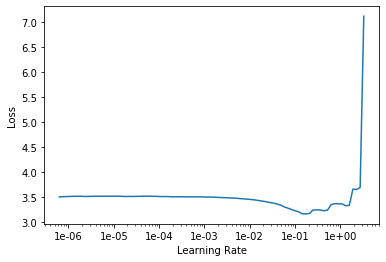

In [31]:
learn.recorder.plot()

In [32]:
data.empty_val=False

In [40]:
learn.fit_one_cycle(25, 4e-2)

epoch,train_loss,valid_loss,seq2seq_acc,time
0,0.612582,0.570931,0.813059,00:20
1,0.686607,0.615983,0.796668,00:20
2,0.619057,0.633115,0.792349,00:21
3,0.761071,0.620560,0.800334,00:21
4,0.750448,0.650200,0.788232,00:20
5,0.716639,0.679755,0.789590,00:20
6,0.803896,0.824094,0.733160,00:20
7,0.871752,0.847263,0.744414,00:22
8,0.954145,0.721140,0.784024,00:21
9,0.857448,0.766350,0.757282,00:21


KeyboardInterrupt: 

In [34]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.data.valid_dl):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(x)
                targets.append(y)
                outputs.append(z.argmax(1))
    return inputs, targets, outputs

In [35]:
inputs, targets, outputs = get_predictions(learn)

In [36]:
i=9

In [37]:
" * ".join(proc_num.deprocess([inputs[i].cpu().tolist()])[0])

'A_SUBMITTED * A_PARTLYSUBMITTED * A_PREACCEPTED * W_Completeren aanvraag * W_Completeren aanvraag * A_ACCEPTED * A_FINALIZED * O_SELECTED * O_CREATED * O_SENT * W_Nabellen offertes * W_Completeren aanvraag * W_Nabellen offertes * O_SELECTED * O_CANCELLED * O_CREATED * O_SENT * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * O_SELECTED * O_CANCELLED * O_CREATED * O_SENT * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * O_SELECTED * O_CANCELLED * O_CREATED * O_SENT * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad * xxpad

In [38]:
" * ".join(proc_num.deprocess([targets[i].cpu().tolist()])[0])

'W_Nabellen offertes * O_SENT_BACK * W_Valideren aanvraag * W_Nabellen offertes * W_Valideren aanvraag * W_Valideren aanvraag * W_Valideren aanvraag * W_Nabellen incomplete dossiers * W_Valideren aanvraag * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Valideren aanvraag * W_Nabellen incomplete dossiers * W_Valideren aanvraag * W_Nabellen incomplete dossiers * W_Valideren aanvraag * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Valideren aanvraag * W_Nabellen incomplete dossiers * W_Valideren aanvraag * O_ACCEPTED * A_APPROVED * A_REGISTERED * A_ACTIVATE

In [39]:
" * ".join(proc_num.deprocess([outputs[i].cpu().tolist()])[0])

'W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen offertes * W_Nabellen incomplete dossiers * W_Nabellen offertes * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Valideren aanvraag * W_Valideren aanvraag'

In [29]:
iter_dl = iter(t_dl)
xb,yb = next(iter_dl)

In [41]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - 0.5 * epoch/self.end_epoch

In [42]:
class Seq2SeqQRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, n_hid, max_len, n_layers=2, p_inp:float=0.15, p_enc:float=0.25, 
                 p_dec:float=0.1, p_out:float=0.35, p_hid:float=0.05, bos_idx:int=0, pad_idx:int=1):
        super().__init__()
        self.n_layers,self.n_hid,self.max_len,self.bos_idx,self.pad_idx = n_layers,n_hid,max_len,bos_idx,pad_idx
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(p_inp)
        self.encoder = QRNN(emb_enc.weight.size(1), n_hid, n_layers=n_layers, dropout=p_enc)
        self.out_enc = nn.Linear(n_hid, emb_enc.weight.size(1), bias=False)
        self.hid_dp  = nn.Dropout(p_hid)
        self.emb_dec = emb_dec
        self.decoder = QRNN(emb_dec.weight.size(1), emb_dec.weight.size(1), n_layers=n_layers, dropout=p_dec)
        self.out_drop = nn.Dropout(p_out)
        self.out = nn.Linear(emb_dec.weight.size(1), emb_dec.weight.size(0))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def forward(self, inp, targ=None):
        bs,sl = inp.size()
        hid = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.encoder(emb, hid)
        hid = self.out_enc(self.hid_dp(hid))

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        res = []
        for i in range(self.max_len):
            emb = self.emb_dec(dec_inp).unsqueeze(1)
            outp, hid = self.decoder(emb, hid)
            outp = self.out(self.out_drop(outp[:,0]))
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: break
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.n_layers, bs, self.n_hid)

In [43]:
emb_enc = create_emb(proc_num.vocab,em_sz=16)
emb_dec = create_emb(proc_num.vocab,em_sz=16)


In [44]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 30, n_layers=2)
learn = Learner(data, model.cuda(), loss_func=seq2seq_loss, metrics=[seq2seq_acc],
                callback_fns=partial(TeacherForcing, end_epoch=8))

In [45]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,time
0,2.387480,2.885957,0.134286,00:22
1,0.891848,1.870000,0.561487,00:22
2,0.593510,2.117422,0.643699,00:22
3,0.492097,1.937095,0.637832,00:21
4,0.511218,2.131192,0.602447,00:22
5,0.552228,1.317405,0.688032,00:21
6,0.522177,1.279400,0.673095,00:21
7,0.607179,1.029300,0.679754,00:22
8,0.543112,1.040118,0.685587,00:21
9,0.672243,0.780057,0.752226,00:21


In [50]:
i=567

In [51]:
" * ".join(proc_num.deprocess([inputs[i].cpu().tolist()])[0])

'A_SUBMITTED * A_PARTLYSUBMITTED * A_PREACCEPTED * W_Completeren aanvraag * W_Completeren aanvraag * W_Completeren aanvraag * W_Completeren aanvraag * A_ACCEPTED * O_SELECTED * A_FINALIZED * O_CREATED * O_SENT * W_Nabellen offertes * W_Completeren aanvraag * W_Nabellen offertes * O_SENT_BACK * W_Valideren aanvraag * W_Nabellen offertes * W_Valideren aanvraag * W_Valideren aanvraag * W_Valideren aanvraag * W_Nabellen incomplete dossiers * W_Valideren aanvraag * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * xxpad * xxpad'

In [52]:
" * ".join(proc_num.deprocess([targets[i].cpu().tolist()])[0])

'W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * O_CANCELLED * A_CANCELLED * W_Nabellen incomplete dossiers * xxeot * xxpad * xxpad'

In [53]:
" * ".join(proc_num.deprocess([outputs[i].cpu().tolist()])[0])

'W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Nabellen incomplete dossiers * W_Valideren aanvraag * W_Valideren aanvraag * W_Valideren aanvraag * W_Valideren aanvraag * xxeot'

In [29]:
iter_dl = iter(t_dl)
xb,yb = next(iter_dl)

In [ ]:
"*".join(proc_num.deprocess(inputs[3:4])[0])

In [ ]:
inputs[3].cpu().tolist()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [ ]:
cbs = [
       partial(AvgStatsCallback,seq2seq_acc),
       CudaCallback,
        Recorder,
    
        partial(ParamScheduler, 'lr', sched),
     #  partial(GradientClipping, clip=0.1),
       ProgressBarCallback]

In [ ]:
data=suffix_databunchify(ll,2*1048)

In [ ]:
emb_enc = create_emb(proc_num.vocab,em_sz=16)
emb_dec = create_emb(proc_num.vocab,em_sz=16)


In [ ]:
CudaCallback??

In [ ]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 64, 174, n_layers=2)


In [ ]:
learn = Learner(model, data, seq2seq_loss, lr=1e-3, cb_funcs=cbs, opt_func=adam_opt())

In [ ]:
learn.fit(20)

In [ ]:
class TeacherForcing(Callback):
    
    def __init__(self, end_epoch):
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.model.pr_force = 1 - 0.5 * epoch/self.end_epoch

In [ ]:
class Seq2SeqQRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, n_hid, max_len, n_layers=2, p_inp:float=0.15, p_enc:float=0.25, 
                 p_dec:float=0.1, p_out:float=0.35, p_hid:float=0.05, bos_idx:int=0, pad_idx:int=1):
        super().__init__()
        self.n_layers,self.n_hid,self.max_len,self.bos_idx,self.pad_idx = n_layers,n_hid,max_len,bos_idx,pad_idx
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(p_inp)
        self.encoder = QRNN(emb_enc.weight.size(1), n_hid, n_layers=n_layers, dropout=p_enc)
        self.out_enc = nn.Linear(n_hid, emb_enc.weight.size(1), bias=False)
        self.hid_dp  = nn.Dropout(p_hid)
        self.emb_dec = emb_dec
        self.decoder = QRNN(emb_dec.weight.size(1), emb_dec.weight.size(1), n_layers=n_layers, dropout=p_dec)
        self.out_drop = nn.Dropout(p_out)
        self.out = nn.Linear(emb_dec.weight.size(1), emb_dec.weight.size(0))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def forward(self, inp, targ=None):
        bs,sl = inp.size()
        hid = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.encoder(emb, hid)
        hid = self.out_enc(self.hid_dp(hid))

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        res = []
        for i in range(self.max_len):
            emb = self.emb_dec(dec_inp).unsqueeze(1)
            outp, hid = self.decoder(emb, hid)
            outp = self.out(self.out_drop(outp[:,0]))
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: break
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.n_layers, bs, self.n_hid)

In [ ]:
cbs = [
       partial(AvgStatsCallback,seq2seq_acc),
       CudaCallback,
        Recorder,
        partial(TeacherForcing, end_epoch=8),
        partial(ParamScheduler, 'lr', sched),
     #  partial(GradientClipping, clip=0.1),
       ProgressBarCallback]

In [ ]:
emb_enc = create_emb(proc_num.vocab,em_sz=16)
emb_dec = create_emb(proc_num.vocab,em_sz=16)


In [ ]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 100, n_layers=2)
learn = Learner(model, data, seq2seq_loss, lr=1e-5, cb_funcs=cbs, opt_func=adam_opt())

In [ ]:
learn.fit(15)

In [ ]:
xb.shape

In [ ]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, itos, em_sz_enc, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = nn.Embedding(len(itos), em_sz_enc, padding_idx=1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
                        
        self.emb_dec = nn.Embedding(len(itos), em_sz_dec, padding_idx=1)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos))
        self.out.weight.data = self.emb_dec.weight.data

    def forward(self, inp):
        bs,sl = inp.size()
        h = self.initHidden(inp,bs)
       
        emb = self.emb_enc_drop(self.emb_enc(inp.T))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = Variable(inp.new_zeros(bs))
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = Variable(outp.data.max(1)[1].float()).long()
            if (dec_inp==1).all(): break
        res=torch.stack(res)
        return res
    
    def initHidden(self,t, bs): 
        #return Variable(torch.zeros(self.nl, bs, self.nh))
        return Variable(t.new_zeros((self.nl, bs, self.nh)).float())


In [ ]:
def seq2seq_loss(input, target):
    bs,sl = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.reshape(-1,nc), target.T.reshape(-1))#, ignore_index=1)

In [ ]:
model=Seq2SeqRNN(proc_num.vocab,10,10,8,174)
pred=model(xb);pred.shape

In [ ]:
yb.shape

In [ ]:
seq2seq_loss(pred,yb)

In [ ]:
from torch.autograd import Variable



In [ ]:
cbs = [
       #partial(AvgStatsCallback,accuracy_flat),
       CudaCallback, Recorder,
       partial(GradientClipping, clip=0.1),
       ProgressBarCallback]

In [ ]:
data=suffix_databunchify(ll,64)

In [ ]:
learn = Learner(Seq2SeqRNN(proc_num.vocab,10,10,8,174), data, seq2seq_loss, lr=5e-3, cb_funcs=cbs, opt_func=adam_opt())

In [ ]:
learn.fit(50)